In [66]:
%load_ext autoreload
%autoreload 2
from matplotlib.path import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import argparse
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import polygon_primitives.file_writer as fw

from image_processing import extract_window_wall_ratio, utils, contour_extraction
from scipy.spatial import Delaunay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
%pwd

'/Users/stouzani/Desktop/Unstructured_ML/DL_Models/a3dbr/Example_Notebooks'

First, we set the image and parameter directories, as well as the merged polygons file path. We load the merged polygons, as we also initialize a dictionary for the Cameras. The Camera class stores all information related to the camera, i.e. intrinsic and extrinsic camera parameters.

In [68]:
#Example file
filename = "DJI_0033.JPG"

#directory = "../data/Drone_Flight/"
facade_file = "/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/Data_results/merged_polygons.txt"#"../data/Drone_Flight/merged.txt"

image_dir = "/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/dji_demo/images/" #directory + "RGB/"
param_dir = "/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/pix4d_HQ/1_initial/params/" #directory + "params/"
#predictions_dir = directory + "predictions/"

offset = np.loadtxt(param_dir + "pix4d_HQ_offset.xyz",usecols=range(3)) #offset = np.loadtxt(param_dir + "offset.txt",usecols=range(3))

#Initializes a dictionary of Camera classes. See utils.py for more information.
camera_dict = utils.create_camera_dict(param_dir, filename="pix4d_HQ_calibrated_camera_parameters.txt", offset=offset)

#Loads pmatrices and image filenamees
p_matrices = np.loadtxt(param_dir + 'pix4d_HQ_pmatrix.txt', usecols=range(1,13)) # p_matrices = np.loadtxt(param_dir + 'pmatrix.txt', usecols=range(1,13))

#Loads the merged polygons, as well as a list of facade types (i.e. roof, wall, or floor)
merged_polygons, facade_type_list, file_format = fw.load_merged_polygon_facades(filename=facade_file)

#Offset adjustment parameter
# height_adj = np.array([0.0, 0.0, 108])
# offset = offset + height_adj
polygon_offset = np.loadtxt("/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/Data_results/polygon_offset.txt", delimiter=",")
#Adjust height if necessary for the camera images
height_adj = -polygon_offset[2]  #108.0#108.0
offset_adj = np.array([0.0, 0.0, height_adj])
offset = offset + offset_adj


Next, we extract the contours for the window predictions, by taking the window prediction points and using them to create a shapely polygon.

Window predictions: 


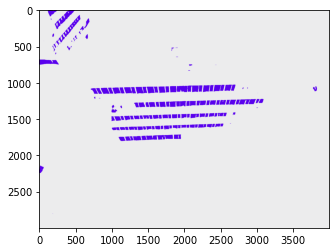

Extracted contours: 


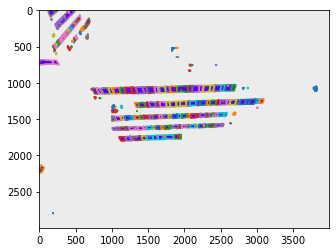

In [73]:
window_file = "/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/dji_demo/masks_2/DJI_0033.png" 
# window_file ='/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/dji_demo/mask_GT/DJI_0033_pink.png'

print("Window predictions: ")
image = cv2.imread(window_file)
plt.imshow(image)
plt.show()

#Extract the contours of the window file
contours = contour_extraction.extract_contours(window_file)

#Create polygons from the window contours
window_polygons = utils.convert_polygons_shapely(contours)


def plot_shapely_polys(image_file, polys):
    for poly in polys:
        s = poly
        s = poly.simplify(0.1, preserve_topology=True)
        x,y = s.exterior.xy
        plt.plot(x,y)
    plt.show()

print("Extracted contours: ")
plt.imshow(image)
plot_shapely_polys(window_file, window_polygons)

Finally, for each window point, we obtain its 3D coordinates and use them to calculate the window to wall ratio.

In [74]:
camera = camera_dict[filename]
pmatrix = camera.calc_pmatrix()
# print(pmatrix)

image_file = utils.load_image(image_dir + filename)
# print(image_dir + filename)

#Projects the merged polygon facades onto the camera image
projected_facades, projective_distances = extract_window_wall_ratio.project_merged_polygons(
    merged_polygons, offset, pmatrix)
# print(projected_facades)
#Creates a dictionary mapping the facade to the windows contained within them, keyed by facade index
facade_window_map = extract_window_wall_ratio.get_facade_window_map(
    window_polygons, projected_facades, projective_distances)
# print(facade_window_map)
#Creates a list of all the facades in the merged polygon
facades = []
for poly in merged_polygons:
    facades = facades + poly

facade_indices = list(facade_window_map.keys())
# print(facade_indices)
for i in facade_indices:
    #Computes window to wall ratio
    win_wall_ratio = extract_window_wall_ratio.get_window_wall_ratio(
        projected_facades[i], facades[i], facade_window_map[i])

    #Output printing:
    print("Facade index: " + str(i))
    print("Window-to-wall ratio: " + str(win_wall_ratio))
    
    #Uncomment this line to plot the windows and facades on the image
#     extract_window_wall_ratio.plot_windows_facade(projected_facades[i], facade_window_map[i], image_file)

facade_area: 538.634465447367
None
window_area: 115.04176815306703
None
Facade index: 2
Window-to-wall ratio: 0.2135804066260747
facade_area: 911.3013916015625
None
window_area: 0.573974609375
None
Facade index: 5
Window-to-wall ratio: 0.000629840593534342


# convert json to mask (ground truth)

In [28]:
import json
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageChops
data = json.load(open('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/dji_demo/mask_GT/DJI_0033.json'))

In [59]:
nested_lst_of_tuples = []
for i in range(len(data.get("objects"))):
    objects = data.get("objects")[i]
    points_lab = objects['points']
    nested_lists = points_lab['exterior']
    nested_lst_of_tuples0 = [tuple(l) for l in nested_lists]
    nested_lst_of_tuples.append(nested_lst_of_tuples0)


In [61]:
def getMask(original,polygon):
    #Returns the mask of the polygon
    mask = Image.new('L', original.size, 0)
    mask_draw = ImageDraw.Draw(mask)
    for i in range(len(data.get("objects"))):
        mask_draw.polygon(polygon[i], outline=1, fill=1)
    return np.array(mask)

In [62]:
original=Image.open(image_dir + filename)
mask = getMask(original,nested_lst_of_tuples)

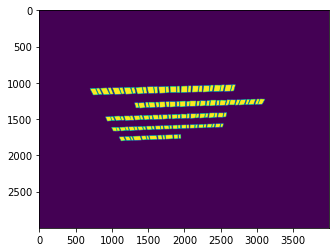

In [63]:
plt.figure()
plt.imshow(mask)

In [65]:
import matplotlib

matplotlib.image.imsave('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/pix4d_HQ/dji_demo/mask_GT/DJI_0033.png', mask)